In [3]:
import os
import sys

notebook_dir = os.getcwd()
app_path = os.path.abspath(os.path.join(notebook_dir, "../"))
if app_path not in sys.path:
    sys.path.insert(0, app_path)

In [4]:
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

True

## 노드 정의

In [5]:
import os
from graphparser_backup.state import GraphState
import graphparser_backup.core as parser_core
import graphparser_backup.pdf as pdf


# 문서 분할
split_pdf_node = pdf.SplitPDFFilesNode(batch_size=10)

# Layout Analyzer
layout_analyze_node = parser_core.LayoutAnalyzerNode(os.environ.get("UPSTAGE_API_KEY"))

# 페이지 요소 추출
page_element_extractor_node = parser_core.ExtractPageElementsNode()

# 이미지 자르기
image_cropper_node = parser_core.ImageCropperNode()

# 테이블 자르기
table_cropper_node = parser_core.TableCropperNode()

# 페이지별 텍스트 추출
extract_page_text = parser_core.ExtractPageTextNode()

# 페이지별 요약
page_summary_node = parser_core.CreatePageSummaryNode(
    api_key=os.environ.get("OPENAI_API_KEY")
)

# 이미지 요약
image_summary_node = parser_core.CreateImageSummaryNode(
    api_key=os.environ.get("OPENAI_API_KEY")
)

# 테이블 요약
table_summary_node = parser_core.CreateTableSummaryNode(
    api_key=os.environ.get("OPENAI_API_KEY")
)

# 테이블 Markdown 추출
table_markdown_extractor = parser_core.TableMarkdownExtractorNode()

## 그래프 정의

In [6]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# LangGraph을 생성
workflow = StateGraph(GraphState)

# 노드들을 정의합니다.
workflow.add_node("split_pdf_node", split_pdf_node)
workflow.add_node("layout_analyzer_node", layout_analyze_node)
workflow.add_node("page_element_extractor_node", page_element_extractor_node)
workflow.add_node("image_cropper_node", image_cropper_node)
workflow.add_node("table_cropper_node", table_cropper_node)
workflow.add_node("extract_page_text_node", extract_page_text)
workflow.add_node("page_summary_node", page_summary_node)
workflow.add_node("image_summary_node", image_summary_node)
workflow.add_node("table_summary_node", table_summary_node)
workflow.add_node("table_markdown_node", table_markdown_extractor)

# 각 노드들을 연결합니다.
workflow.add_edge("split_pdf_node", "layout_analyzer_node")
workflow.add_edge("layout_analyzer_node", "page_element_extractor_node")
workflow.add_edge("page_element_extractor_node", "image_cropper_node")
workflow.add_edge("page_element_extractor_node", "table_cropper_node")
workflow.add_edge("page_element_extractor_node", "extract_page_text_node")
workflow.add_edge("image_cropper_node", "page_summary_node")
workflow.add_edge("table_cropper_node", "page_summary_node")
workflow.add_edge("extract_page_text_node", "page_summary_node")
workflow.add_edge("page_summary_node", "image_summary_node")
workflow.add_edge("page_summary_node", "table_summary_node")
workflow.add_edge("image_summary_node", END)
workflow.add_edge("table_summary_node", "table_markdown_node")
workflow.add_edge("table_markdown_node", END)

workflow.set_entry_point("split_pdf_node")

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

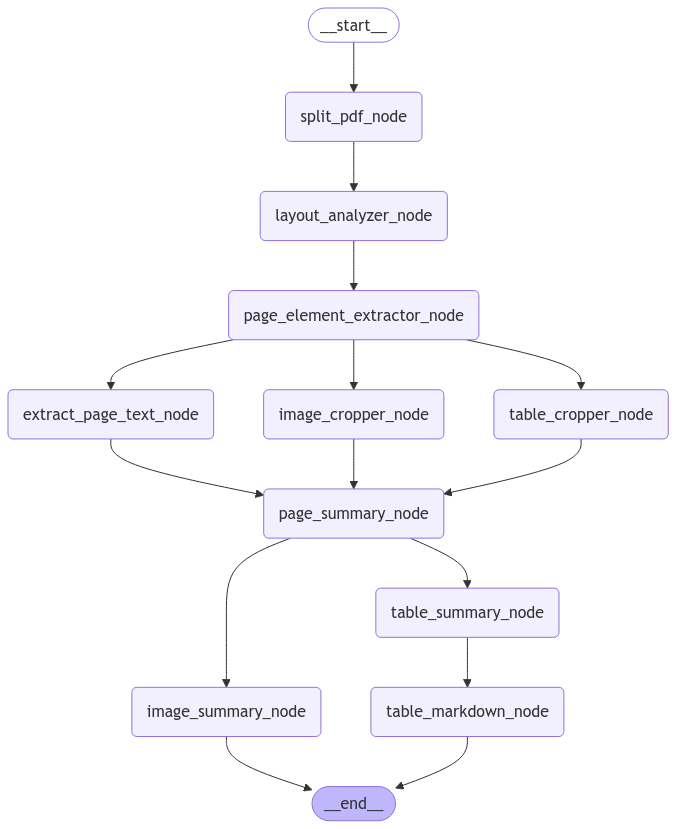

In [7]:
from IPython.display import Image, display

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. xray=True는 추가적인 세부 정보를 포함합니다.
except:
    # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
    pass

아래의 링크에서 데이터를 다운로드 받습니다.
- [샘플 데이터 링크](https://www.innovation.go.kr/ucms/bbs/B0000051/view.do?nttId=3801&menuNo=300145&searchType=&pageIndex=&searchType=)

In [8]:
### 설정 파라미터 ###
FILEPATH = "../data/sample_pdf.pdf"
LANGUAGE = "Korean"
### 설정 파라미터 ###

In [9]:
import pprint
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    recursion_limit=100, configurable={"thread_id": "research-paper"}
)

# AgentState 객체를 활용하여 질문을 입력합니다.
inputs = GraphState(filepath=FILEPATH, language=LANGUAGE)

# app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
try:
    for output in app.stream(inputs, config=config):
        # 출력된 결과에서 키와 값을 순회합니다.
        for key, value in output.items():
            # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
            pprint.pprint(f"Output from node '{key}':")
            pprint.pprint("---")
            # 출력 값을 예쁘게 출력합니다.
            pprint.pprint(value, indent=2, width=80, depth=None)
        # 각 출력 사이에 구분선을 추가합니다.
        pprint.pprint("\n---\n")
except GraphRecursionError as e:
    pprint.pprint(f"Recursion limit reached: {e}")

총 페이지 수: 6
분할 PDF 생성: ../data/sample_pdf_0000_0005.pdf
"Output from node 'split_pdf_node':"
'---'
{'split_filepaths': ['../data/sample_pdf_0000_0005.pdf']}
'\n---\n'
"Output from node 'layout_analyzer_node':"
'---'
{'analyzed_files': ['../data/sample_pdf_0000_0005.json']}
'\n---\n'
("data: {'api': '2.0', 'content': {'html': '<header id=\\'0\\' "
 "style=\\'font-size:14px\\'>2020 한국자동차공학회</header>\\n<br><header id=\\'1\\' "
 "style=\\'font-size:14px\\'>Copyright ⓒ 2020 "
 "KSAE<br>20AKSAE_A004</header>\\n<h1 id=\\'2\\' "
 "style=\\'font-size:20px\\'>회귀분석법을 이용한 차량 오일펌프의 인로터 중량 최적화 해석<br>정대근1)* "
 "김기태1)<br>명화공업1)</h1>\\n<h1 id=\\'3\\' style=\\'font-size:22px\\'>In-rotor "
 'weight optimization analysis of vehicle oil pump using '
 "regression<br>analysis method</h1>\\n<p id=\\'4\\' "
 "data-category=\\'paragraph\\' style=\\'font-size:18px\\'>Dae-geun Jung1) "
 "Ki-Tae Kim1)</p>\\n<p id=\\'5\\' data-category=\\'paragraph\\' "
 "style=\\'font-size:14px\\'>1) MYUNGHWA IND. CO., LTD. R&D Cen

In [10]:
state = app.get_state(config).values

In [11]:
state

{'filepath': '../data/sample_pdf.pdf',
 'page_numbers': [0, 1, 2, 3, 4, 5],
 'split_filepaths': ['../data/sample_pdf_0000_0005.pdf'],
 'analyzed_files': ['../data/sample_pdf_0000_0005.json'],
 'page_elements': {0: {'image_elements': [],
   'table_elements': [],
   'text_elements': [{'category': 'header',
     'content': {'html': "<header id='0' style='font-size:14px'>2020 한국자동차공학회</header>",
      'markdown': '2020 한국자동차공학회',
      'text': '2020 한국자동차공학회'},
     'coordinates': [{'x': 0.0882, 'y': 0.045},
      {'x': 0.2806, 'y': 0.045},
      {'x': 0.2806, 'y': 0.0603},
      {'x': 0.0882, 'y': 0.0603}],
     'id': 0,
     'page': 0},
    {'category': 'header',
     'content': {'html': "<br><header id='1' style='font-size:14px'>Copyright ⓒ 2020 KSAE<br>20AKSAE_A004</header>",
      'markdown': 'Copyright ⓒ 2020 KSAE\n20AKSAE_A004',
      'text': 'Copyright ⓒ 2020 KSAE\n20AKSAE_A004'},
     'coordinates': [{'x': 0.7408, 'y': 0.0322},
      {'x': 0.9136, 'y': 0.0322},
      {'x': 0.9136,

## 저장 및 불러오기

In [12]:
from graphparser.layout_utils import save_state, load_state

# 상태 저장
save_state(state, FILEPATH)

# 상태 불러오기
loaded_state = load_state(FILEPATH)
loaded_state

{'filepath': '../data/sample_pdf.pdf',
 'page_numbers': [0, 1, 2, 3, 4, 5],
 'split_filepaths': ['../data/sample_pdf_0000_0005.pdf'],
 'analyzed_files': ['../data/sample_pdf_0000_0005.json'],
 'page_elements': {0: {'image_elements': [],
   'table_elements': [],
   'text_elements': [{'category': 'header',
     'content': {'html': "<header id='0' style='font-size:14px'>2020 한국자동차공학회</header>",
      'markdown': '2020 한국자동차공학회',
      'text': '2020 한국자동차공학회'},
     'coordinates': [{'x': 0.0882, 'y': 0.045},
      {'x': 0.2806, 'y': 0.045},
      {'x': 0.2806, 'y': 0.0603},
      {'x': 0.0882, 'y': 0.0603}],
     'id': 0,
     'page': 0},
    {'category': 'header',
     'content': {'html': "<br><header id='1' style='font-size:14px'>Copyright ⓒ 2020 KSAE<br>20AKSAE_A004</header>",
      'markdown': 'Copyright ⓒ 2020 KSAE\n20AKSAE_A004',
      'text': 'Copyright ⓒ 2020 KSAE\n20AKSAE_A004'},
     'coordinates': [{'x': 0.7408, 'y': 0.0322},
      {'x': 0.9136, 'y': 0.0322},
      {'x': 0.9136,

In [13]:
state = loaded_state

In [14]:
state["image_summary"]

{22: '<image>\n<title>\n중량 최적화 자동 시트 개발\n</title>\n<summary>\n이 이미지는 중량 최적화 자동 시트 개발과 관련된 부품으로 보입니다. 기존의 문제점은 초기 설계 후 해석을 통한 강도 검증과 중량 절감 검토가 필요하다는 것이며, 중량 최적화 결과는 최선이 아니고 많은 시간이 소요되었습니다. 설계 파라미터별 중량 최적화를 통해 업무 간소화 및 효율성을 극대화하고, 강도 수준 만족을 위한 설계 파라미터 선정 및 선형 강도 해석을 수행하였습니다. 확보된 시간은 기술 고도화 연구에 투자할 수 있습니다.\n</summary>\n<entities> \n- 중량 최적화\n- 강도 검증\n- 설계 파라미터\n- 선형 강도 해석\n- 기술 고도화 연구\n</entities>\n<hypothetical_questions>\n1. 중량 최적화 자동 시트 개발의 주요 목표는 무엇인가요?\n2. 기존 문제점으로 지적된 강도 검증 과정은 어떻게 개선될 수 있나요?\n3. 설계 파라미터별 중량 최적화의 구체적인 방법은 무엇인가요?\n4. 강도 수준 만족을 위한 설계 파라미터 선정 기준은 무엇인가요?\n5. 확보된 시간을 기술 고도화 연구에 어떻게 활용할 수 있나요?\n</hypothetical_questions>\n</image>',
 25: '<image>\n<title>\n중량 최적화 자동 시트 개발 프로세스\n</title>\n<summary>\n이 이미지는 중량 최적화 자동 시트 개발을 위한 프로세스를 나타냅니다. 모델 선정 및 고정, 설계 파라미터 인자 설정, CAE 해석, 중량 최적화, 신뢰성 평가, 그리고 업무 활용의 단계로 구성되어 있습니다. 각 단계는 중량 절감과 강도 검증을 위한 필수 작업을 포함하고 있습니다.\n</summary>\n<entities> \n- 모델 선정 및 고정\n- 설계 파라미터 인자 설정\n- CAE 해석\n- 중량 최적화\n- 신뢰성 평가\n- 업무 활용\n</entities>\n<hypothetica

## Markdown 생성

In [15]:
# print(state["image_summary"][24])

In [16]:
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
import re


def extract_tag_content(content, tag):
    pattern = rf"<{tag}>(.*?)</{tag}>"
    match = re.search(pattern, content, re.DOTALL)

    if match:
        return match.group(1).strip()
    else:
        return None


def extract_non_tag_content(content, tag):
    pattern = rf"<{tag}>.*?</{tag}>"
    result = re.sub(pattern, "", content, flags=re.DOTALL)
    return result.strip()

### Image, Table 에서 추출된 데이터 Vector DB 생성을 위한 문서 생성

- Title, Summary, Entities 는 임베딩 검색에 걸리기 위한 문서로 생성
- hypothetical_questions 는 임베딩 검색에 걸리기 위한 문서로 생성

In [17]:
for i in state["image_summary"]:
    print(
        state["image_summary"][i],
        end="\n=============================================================================================================================================================\n",
    )

<image>
<title>
중량 최적화 자동 시트 개발
</title>
<summary>
이 이미지는 중량 최적화 자동 시트 개발과 관련된 부품으로 보입니다. 기존의 문제점은 초기 설계 후 해석을 통한 강도 검증과 중량 절감 검토가 필요하다는 것이며, 중량 최적화 결과는 최선이 아니고 많은 시간이 소요되었습니다. 설계 파라미터별 중량 최적화를 통해 업무 간소화 및 효율성을 극대화하고, 강도 수준 만족을 위한 설계 파라미터 선정 및 선형 강도 해석을 수행하였습니다. 확보된 시간은 기술 고도화 연구에 투자할 수 있습니다.
</summary>
<entities> 
- 중량 최적화
- 강도 검증
- 설계 파라미터
- 선형 강도 해석
- 기술 고도화 연구
</entities>
<hypothetical_questions>
1. 중량 최적화 자동 시트 개발의 주요 목표는 무엇인가요?
2. 기존 문제점으로 지적된 강도 검증 과정은 어떻게 개선될 수 있나요?
3. 설계 파라미터별 중량 최적화의 구체적인 방법은 무엇인가요?
4. 강도 수준 만족을 위한 설계 파라미터 선정 기준은 무엇인가요?
5. 확보된 시간을 기술 고도화 연구에 어떻게 활용할 수 있나요?
</hypothetical_questions>
</image>
<image>
<title>
중량 최적화 자동 시트 개발 프로세스
</title>
<summary>
이 이미지는 중량 최적화 자동 시트 개발을 위한 프로세스를 나타냅니다. 모델 선정 및 고정, 설계 파라미터 인자 설정, CAE 해석, 중량 최적화, 신뢰성 평가, 그리고 업무 활용의 단계로 구성되어 있습니다. 각 단계는 중량 절감과 강도 검증을 위한 필수 작업을 포함하고 있습니다.
</summary>
<entities> 
- 모델 선정 및 고정
- 설계 파라미터 인자 설정
- CAE 해석
- 중량 최적화
- 신뢰성 평가
- 업무 활용
</entities>
<hypothetical_questions>
1. 중량 최적화 자동 시트 개발의 첫 번째 단계는 무엇인가요?
2

In [18]:
# print(extract_tag_content(state["image_summary"][24], "hypothetical_questions"))

In [19]:
# print(extract_non_tag_content(state["image_summary"][24], "hypothetical_questions"))

### Table

In [20]:
state["table_summary"]

{30: '<table>\n<title>\n설계 파라미터 및 범위 요약\n</title>\n<summary>\n이 표는 중량 최적화 자동 시트 개발을 위한 설계 파라미터와 그 범위를 정리한 것입니다. 각 파라미터는 특정 범위 내에서 설정되어 강도 검증 및 중량 절감에 기여합니다.\n</summary>\n<entities> \n- 설계 파라미터 A: D10.0~D12 mm\n- 설계 파라미터 B: 40.12~46.59 mm (47.31도~55.54도)\n- 설계 파라미터 C: 1.0~3.0 mm\n- 설계 파라미터 D: 0.5~1.5 mm\n- 설계 파라미터 E: 16.6~27.0 mm\n</entities>\n<data_insights>\n- 설계 파라미터 A는 직경 범위를 나타내며, B는 길이와 각도를 포함합니다.\n- C, D, E는 각각 두께 및 길이 범위를 나타내며, 중량 최적화에 중요한 역할을 합니다.\n</data_insights>\n<hypothetical_questions>\n1. 설계 파라미터 A의 범위는 무엇인가요?\n2. 중량 최적화 자동 시트 개발의 주요 목표는 무엇인가요?\n3. 설계 파라미터 B의 각도 범위는 어떻게 되나요?\n4. 강도 검증을 위한 설계 파라미터 선정 과정은 어떻게 이루어지나요?\n5. 확보된 시간을 기술 고도화 연구에 어떻게 활용할 수 있나요?\n</hypothetical_questions>\n</table>',
 39: '<table>\n<title>\n베인 인로터 설계 파라미터 분석\n</title>\n<summary>\n이 표는 베인 인로터 설계 파라미터의 회귀식 해석을 위한 데이터로, 독립 변수 5개와 3인자 수준으로 27개 항목이 정렬되어 있습니다. 각 항목은 회전, 외곽 선 고정, 최대 응력 측정 조건 하에 측정된 결과를 포함하고 있습니다.\n</summary>\n<entities> \n- A: 독립 변수\n- B: 특정 파라미터 값\n- C: 인자 수준\n- D: 또 다른 변수\n- E: 측정된 최대 응

In [21]:
# XML 파싱을 위해 import 문을 추가합니다
import xml.etree.ElementTree as ET


def convert_to_markdown_table(table_summary):
    html = "<table>\n"

    # table_summary가 문자열인 경우를 처리합니다
    if isinstance(table_summary, str):
        # XML 파싱을 사용하여 문자열에서 데이터를 추출합니다
        root = ET.fromstring(table_summary)
        for child in root:
            html += f"  <tr>\n    <th>{child.tag}</th>\n    <td>"

            if child.tag in ["entities", "data_insights"]:
                html += "<ul>\n"
                for item in child.text.strip().split("\n- "):
                    if item.strip():
                        html += f"      <li>{item.strip()}</li>\n"
                html += "    </ul>"
            elif child.tag == "hypothetical_questions":
                html += "<ol>\n"
                for item in child.text.strip().split("\n"):
                    if item.strip():
                        html += f"      <li>{item.strip()}</li>\n"
                html += "    </ol>"
            else:
                html += child.text.strip()

            html += "</td>\n  </tr>\n"
    else:
        # 기존의 딕셔너리 처리 로직을 유지합니다
        for key, value in table_summary.items():
            html += f"  <tr>\n    <th>{key}</th>\n    <td>"

            if key in ["entities", "data_insights"]:
                html += "<ul>\n"
                for item in value.split("\n- "):
                    if item.strip():
                        html += f"      <li>{item.strip()}</li>\n"
                html += "    </ul>"
            elif key == "hypothetical_questions":
                html += "<ol>\n"
                for item in value.split("\n"):
                    if item.strip():
                        html += f"      <li>{item.strip()}</li>\n"
                html += "    </ol>"
            else:
                html += value

            html += "</td>\n  </tr>\n"

    html += "</table>"
    return html

In [22]:
# print(state["table_summary"][31])

In [23]:
# markdown_table = convert_to_markdown_table(state["table_summary"][31])
# print(markdown_table)

In [24]:
state

{'filepath': '../data/sample_pdf.pdf',
 'page_numbers': [0, 1, 2, 3, 4, 5],
 'split_filepaths': ['../data/sample_pdf_0000_0005.pdf'],
 'analyzed_files': ['../data/sample_pdf_0000_0005.json'],
 'page_elements': {0: {'image_elements': [],
   'table_elements': [],
   'text_elements': [{'category': 'header',
     'content': {'html': "<header id='0' style='font-size:14px'>2020 한국자동차공학회</header>",
      'markdown': '2020 한국자동차공학회',
      'text': '2020 한국자동차공학회'},
     'coordinates': [{'x': 0.0882, 'y': 0.045},
      {'x': 0.2806, 'y': 0.045},
      {'x': 0.2806, 'y': 0.0603},
      {'x': 0.0882, 'y': 0.0603}],
     'id': 0,
     'page': 0},
    {'category': 'header',
     'content': {'html': "<br><header id='1' style='font-size:14px'>Copyright ⓒ 2020 KSAE<br>20AKSAE_A004</header>",
      'markdown': 'Copyright ⓒ 2020 KSAE\n20AKSAE_A004',
      'text': 'Copyright ⓒ 2020 KSAE\n20AKSAE_A004'},
     'coordinates': [{'x': 0.7408, 'y': 0.0322},
      {'x': 0.9136, 'y': 0.0322},
      {'x': 0.9136,

In [25]:
state["table_summary"]

{30: '<table>\n<title>\n설계 파라미터 및 범위 요약\n</title>\n<summary>\n이 표는 중량 최적화 자동 시트 개발을 위한 설계 파라미터와 그 범위를 정리한 것입니다. 각 파라미터는 특정 범위 내에서 설정되어 강도 검증 및 중량 절감에 기여합니다.\n</summary>\n<entities> \n- 설계 파라미터 A: D10.0~D12 mm\n- 설계 파라미터 B: 40.12~46.59 mm (47.31도~55.54도)\n- 설계 파라미터 C: 1.0~3.0 mm\n- 설계 파라미터 D: 0.5~1.5 mm\n- 설계 파라미터 E: 16.6~27.0 mm\n</entities>\n<data_insights>\n- 설계 파라미터 A는 직경 범위를 나타내며, B는 길이와 각도를 포함합니다.\n- C, D, E는 각각 두께 및 길이 범위를 나타내며, 중량 최적화에 중요한 역할을 합니다.\n</data_insights>\n<hypothetical_questions>\n1. 설계 파라미터 A의 범위는 무엇인가요?\n2. 중량 최적화 자동 시트 개발의 주요 목표는 무엇인가요?\n3. 설계 파라미터 B의 각도 범위는 어떻게 되나요?\n4. 강도 검증을 위한 설계 파라미터 선정 과정은 어떻게 이루어지나요?\n5. 확보된 시간을 기술 고도화 연구에 어떻게 활용할 수 있나요?\n</hypothetical_questions>\n</table>',
 39: '<table>\n<title>\n베인 인로터 설계 파라미터 분석\n</title>\n<summary>\n이 표는 베인 인로터 설계 파라미터의 회귀식 해석을 위한 데이터로, 독립 변수 5개와 3인자 수준으로 27개 항목이 정렬되어 있습니다. 각 항목은 회전, 외곽 선 고정, 최대 응력 측정 조건 하에 측정된 결과를 포함하고 있습니다.\n</summary>\n<entities> \n- A: 독립 변수\n- B: 특정 파라미터 값\n- C: 인자 수준\n- D: 또 다른 변수\n- E: 측정된 최대 응

In [26]:
def create_document(content, metadata):
    """
    문서 객체를 생성합니다.

    Args:
        content (str): 문서의 내용
        metadata (dict): 문서의 메타데이터

    Returns:
        Document: 생성된 문서 객체
    """
    return Document(page_content=content, metadata=metadata)


def process_image_element(element, state, page_number):
    """
    이미지 요소를 처리합니다.

    Args:
        element (dict): 이미지 요소 정보
        state (dict): 현재 상태
        page_number (str): 페이지 번호

    Returns:
        tuple: 마크다운 문자열과 문서 객체 리스트
    """
    image_id = element["id"]
    image_summary = state["image_summary"][image_id]
    image_path = state["images"][image_id]
    image_path_md = f"![{image_path}]({image_path})"

    # image_summary_md = convert_to_markdown_table(image_summary)
    markdown = f"{image_path_md}"

    image_summary_clean = extract_non_tag_content(
        image_summary, "hypothetical_questions"
    )

    docs = [
        create_document(
            image_summary_clean,
            {
                "type": "image",
                "image": image_path,
                "page": page_number,
                "source": state["filepath"],
                "id": image_id,
            },
        )
    ]

    hypo_docs = []

    hypothetical_questions = extract_tag_content(
        image_summary, "hypothetical_questions"
    )
    if hypothetical_questions != None:
        hypo_docs.append(
            create_document(
                hypothetical_questions,
                {
                    "type": "hypothetical_questions",
                    "image": image_path,
                    "summary": image_summary_clean,
                    "page": page_number,
                    "source": state["filepath"],
                    "id": image_id,
                },
            )
        )

    return markdown, docs, hypo_docs


def process_table_element(element, state, page_number):
    """
    테이블 요소를 처리합니다.

    Args:
        element (dict): 테이블 요소 정보
        state (dict): 현재 상태
        page_number (str): 페이지 번호

    Returns:
        tuple: 마크다운 문자열과 문서 객체
    """
    table_id = element["id"]
    table_summary = state["table_summary"][table_id]
    table_markdown = state["table_markdown"][table_id]
    table_path = state["tables"][table_id]
    table_path_md = f"![{table_path}]({table_path})"

    # table_summary_md = convert_to_markdown_table(table_summary)
    markdown = f"{table_path_md}\n{table_markdown}"

    table_summary_clean = extract_non_tag_content(
        table_summary, "hypothetical_questions"
    )

    docs = [
        create_document(
            table_summary_clean,
            {
                "type": "table",
                "table": table_path,
                "markdown": table_markdown,
                "page": page_number,
                "source": state["filepath"],
                "id": table_id,
            },
        )
    ]

    hypo_docs = []

    hypothetical_questions = extract_tag_content(
        table_summary, "hypothetical_questions"
    )
    if hypothetical_questions != None:
        hypo_docs.append(
            create_document(
                hypothetical_questions,
                {
                    "type": "hypothetical_questions",
                    "table": table_path,
                    "summary": table_summary_clean,
                    "markdown": table_markdown,
                    "page": page_number,
                    "source": state["filepath"],
                    "id": table_id,
                },
            )
        )

    return markdown, docs, hypo_docs


import re
from bs4 import BeautifulSoup

import re
from bs4 import BeautifulSoup


def html_to_markdown(html: str) -> str:
    """
    - <h1> 태그나 font-size:22px인 경우 -> H1
    - font-size:20px -> H2
    - 그 외 -> 일반 텍스트
    - <footer>, <header> 태그는 특별히 로그성 메시지로만 남기고 본문에는 추가하지 않는 예시
    - <br> 태그는 공백으로 치환하여 자연스러운 연결
    """

    soup = BeautifulSoup(html, "html.parser")
    markdown_lines = []

    # 폰트 사이즈를 보고 Heading 레벨을 결정하는 함수
    def get_heading_level_from_font_size(font_size: int) -> int:
        if font_size == 22:
            return 1  # H1
        elif font_size == 20:
            return 2  # H2
        # 다른 폰트 크기는 모두 일반 텍스트
        return 0

    for child in soup.contents:
        # 텍스트 노드거나 태그명이 없으면 건너뜀
        if not hasattr(child, "name") or child.name is None:
            text = child.get_text(strip=True)
            if text:
                markdown_lines.append(text)
            continue

        tag_name = child.name.lower()
        style_attr = child.get("style", "")
        match = re.search(r"font-size:\s*(\d+)px", style_attr)
        font_size = int(match.group(1)) if match else 0

        # <br> 태그를 공백으로 치환
        for br in child.find_all("br"):
            br.replace_with(" ")

        # 요소 텍스트 추출
        text_content = " ".join(child.stripped_strings).strip()
        if not text_content:
            continue

        # <h1> 태그인지, 혹은 font-size=22인지 검사
        if tag_name == "h1":
            heading_level = 1
        else:
            heading_level = get_heading_level_from_font_size(font_size)

        # footer, header 태그 처리 (예: 내용은 넣지 않고 로그만 찍는 예시)
        if tag_name in ["footer", "header"]:
            # footer나 header 내용은 본문에 포함하지 않는 예시
            # 필요하다면 별도 로직으로 markdown_lines.append(...)
            # print(f"[LOG] footer/header tag found: {text_content}")
            continue

        # Heading 레벨에 따라 Markdown 변환
        if heading_level == 1:
            # H1
            markdown_lines.append(f"# {text_content}")
        elif heading_level == 2:
            # H2
            markdown_lines.append(f"## {text_content}")
        else:
            # 일반 문단
            markdown_lines.append(text_content + "\n")

    return "\n".join(markdown_lines)


def process_text_element(element: dict) -> str:
    """
    텍스트 요소(예: element["content"]["html"])를 위 로직으로 Markdown 변환
    """
    html_content = element["content"]["html"]
    return html_to_markdown(html_content)


def process_page(page, state, page_number, text_splitter):
    """
    페이지를 처리합니다.

    Args:
        page (dict): 페이지 정보
        state (dict): 현재 상태
        page_number (str): 페이지 번호
        text_splitter (RecursiveCharacterTextSplitter): 텍스트 분할기

    Returns:
        tuple: 마크다운 문자열 리스트와 문서 객체 리스트
    """
    markdowns = []
    docs = []
    hypo_docs = []
    page_texts = []

    for element in page["elements"]:
        if element["category"] == "figure":
            markdown, element_docs, hypo_doc = process_image_element(
                element, state, page_number
            )
            markdowns.append(markdown)
            docs.extend(element_docs)
            hypo_docs.extend(hypo_doc)
        elif element["category"] == "table":
            markdown, element_docs, hypo_doc = process_table_element(
                element, state, page_number
            )
            markdowns.append(markdown)
            docs.extend(element_docs)
            hypo_docs.extend(hypo_doc)
        else:
            text = process_text_element(element)
            markdowns.append(text)
            page_texts.append(text)

    page_text = "\n".join(page_texts)
    split_texts = text_splitter.split_text(page_text)

    text_summary = state["text_summary"][page_number]

    docs.append(
        create_document(
            text_summary,
            metadata={
                "type": "page_summary",
                "page": page_number,
                "source": state["filepath"],
                "text": page_text,
            },
        )
    )

    for text in split_texts:
        docs.append(
            create_document(
                text,
                metadata={
                    "type": "text",
                    "page": page_number,
                    "source": state["filepath"],
                    "summary": text_summary,
                },
            )
        )

    return markdowns, docs, hypo_docs


def process_document(state):
    """
    전체 문서를 처리합니다.

    Args:
        state (dict): 현재 상태

    Returns:
        tuple: 마크다운 문자열 리스트와 문서 객체 리스트
    """
    markdowns = []
    docs = []
    hypo_docs = []
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)

    for page_number, page in state["page_elements"].items():
        page_markdowns, page_docs, page_hypo_docs = process_page(
            page, state, page_number, text_splitter
        )
        markdowns.extend(page_markdowns)
        docs.extend(page_docs)
        hypo_docs.extend(page_hypo_docs)

    return markdowns, docs, hypo_docs


markdowns, docs, hypo_docs = process_document(state)

In [27]:
# Markdown 파일로 텍스트 저장
with open(FILEPATH.replace(".pdf", ".md"), "w", encoding="utf-8") as f:
    f.write("\n\n".join(markdowns))

print(f"텍스트가 '{FILEPATH.replace('.pdf', '.md')}' 파일로 저장되었습니다.")

텍스트가 '../data/sample_pdf.md' 파일로 저장되었습니다.


In [28]:
len(docs)

36

In [29]:
docs

[Document(metadata={'type': 'page_summary', 'page': 0, 'source': '../data/sample_pdf.pdf', 'text': '\n\n# 회귀분석법을 이용한 차량 오일펌프의 인로터 중량 최적화 해석 정대근1)* 김기태1) 명화공업1)\n# In-rotor weight optimization analysis of vehicle oil pump using regression analysis method\nDae-geun Jung1) Ki-Tae Kim1)\n\n1) MYUNGHWA IND. CO., LTD. R&D Center 65, Beojigi-ro, Danwon-gu, Ansan-si, Gyeonggi-do, Korea\n\nA bstract : This white paper contains information on techniques that can reduce design time. In this study, multiple regression analysis was used as a method to increase work efficiency. The vane, in-rotor of the vehicle oil pump was selected. Variables that can be optimized for weight were selected during design. It has 5 independent variables and 3 factors, which was analyzed by multiple regression. Based on this data, the "Macro" automation sheet was built. As a result of comparing the opimization program and CAE in this paper, the reliability was 91.6%. Through this, the designer can easily and quickly pr

In [30]:
hypo_docs

[Document(metadata={'type': 'hypothetical_questions', 'image': '../data/sample_pdf/22.png', 'summary': '<image>\n<title>\n중량 최적화 자동 시트 개발\n</title>\n<summary>\n이 이미지는 중량 최적화 자동 시트 개발과 관련된 부품으로 보입니다. 기존의 문제점은 초기 설계 후 해석을 통한 강도 검증과 중량 절감 검토가 필요하다는 것이며, 중량 최적화 결과는 최선이 아니고 많은 시간이 소요되었습니다. 설계 파라미터별 중량 최적화를 통해 업무 간소화 및 효율성을 극대화하고, 강도 수준 만족을 위한 설계 파라미터 선정 및 선형 강도 해석을 수행하였습니다. 확보된 시간은 기술 고도화 연구에 투자할 수 있습니다.\n</summary>\n<entities> \n- 중량 최적화\n- 강도 검증\n- 설계 파라미터\n- 선형 강도 해석\n- 기술 고도화 연구\n</entities>\n\n</image>', 'page': 1, 'source': '../data/sample_pdf.pdf', 'id': 22}, page_content='1. 중량 최적화 자동 시트 개발의 주요 목표는 무엇인가요?\n2. 기존 문제점으로 지적된 강도 검증 과정은 어떻게 개선될 수 있나요?\n3. 설계 파라미터별 중량 최적화의 구체적인 방법은 무엇인가요?\n4. 강도 수준 만족을 위한 설계 파라미터 선정 기준은 무엇인가요?\n5. 확보된 시간을 기술 고도화 연구에 어떻게 활용할 수 있나요?'),
 Document(metadata={'type': 'hypothetical_questions', 'image': '../data/sample_pdf/25.png', 'summary': '<image>\n<title>\n중량 최적화 자동 시트 개발 프로세스\n</title>\n<summary>\n이 이미지는 중량 최적화 자동 시트 개발을 위한 프로세스를 나타냅니다. 모델 선정 및 고정, 설계 파라미터 

In [31]:
len(hypo_docs)

10

In [32]:
docs[12].__dict__

{'id': None,
 'metadata': {'type': 'image',
  'image': '../data/sample_pdf/32.png',
  'page': 2,
  'source': '../data/sample_pdf.pdf',
  'id': 32},
 'page_content': '<image>\n<title>\n베인 인로터 설계 파라미터 해석\n</title>\n<summary>\n이 이미지는 베인 인로터 설계의 해석 과정을 보여줍니다. 독립 변수 5개와 3인자 수준으로 27개 항목이 정렬되어 있으며, 중심축 기준으로 10N.m 회전 시 최대 응력을 측정하는 조건에서 해석이 이루어졌습니다. 각 항목은 번호로 구분되어 있으며, 해석 결과는 Y값으로 나타납니다.\n</summary>\n<entities> \n- 베인 인로터\n- 설계 파라미터\n- 독립 변수\n- 최대 응력\n- 해석 결과\n</entities>\n\n</image>',
 'type': 'Document'}

In [33]:
for i, d in enumerate(docs):
    print(i, d.metadata["type"])

0 page_summary
1 text
2 text
3 text
4 text
5 text
6 image
7 image
8 table
9 page_summary
10 text
11 text
12 image
13 table
14 page_summary
15 text
16 text
17 text
18 text
19 text
20 table
21 image
22 image
23 page_summary
24 text
25 text
26 text
27 image
28 table
29 page_summary
30 text
31 text
32 text
33 page_summary
34 text
35 text


In [34]:
print(docs[24].page_content)

Table 3 CAE 주응력 해석 결과

# 라메터(독립변인)들을 갖고 있으므로, 다중 회귀 분석을 사용하였다.
독립변수가 5개인 3인자 수준의 경우 중회귀 모 형은 다음 식(2),(3)와 같다.

$$y_{i}=\beta_{0}+\beta_{1}x_{1i}+\cdots\beta_{5}x_{5i}+\varepsilon_{i}(i=1,5)$$

(2)

(3)

위 중회귀 모형을 행렬식으로 표현하면 다음 식 (4) ~ (6)과 같다.

(4)

$$y=X\beta+\varepsilon\rightarrow\varepsilon=y-X\beta$$

Fig. 4 인로터 CAE 조건

(5)

## 3. 다중 회귀 분석 이론 (multiple regression analysis)
회 귀 분석은 X라는 독립변수와 Y라는 종속변수 간의 인과 관계를 찾기 위한 기업으로 종속변인이 얼마나 변할 것인지에 대한 영향력을 예측하는 통 계 분석 기법이다.

(6)


In [35]:
docs[3].__dict__

{'id': None,
 'metadata': {'type': 'text',
  'page': 0,
  'source': '../data/sample_pdf.pdf',
  'summary': '- 연구 제목: 차량 오일펌프의 인로터 중량 최적화 해석\n- 저자: 정대근, 김기태 (MYUNGHWA IND. CO., LTD. R&D Center)\n- 연구 방법: 다중회귀분석을 이용하여 설계 효율성 증가\n- 최적화 변수: 5개의 독립 변수와 3개의 요인\n- 결과: 최적화 프로그램과 CAE 비교 시 신뢰도 91.6%\n- 목적: CAE 분석 없이 설계 변수를 쉽게 예측 가능하게 함\n- 키워드: 다중회귀분석, 차량, 오일펌프, 베인, 인로터, 최적화'},
 'page_content': 'sheet was built. As a result of comparing the opimization program and CAE in this paper, the reliability was 91.6%. Through this, the designer can easily and quickly predict design variables without CAE analysis.',
 'type': 'Document'}

In [36]:
docs[20].__dict__

{'id': None,
 'metadata': {'type': 'table',
  'table': '../data/sample_pdf/42.png',
  'markdown': '| No. | y    | No | y    | No | y    |\n|-----|------|----|------|----|------|\n| 1   | 113.1 | 10 | 92.0 | 19 | 74.7 |\n| 2   | 55.8  | 11 | 47.7 | 20 | 42.5 |\n| 3   | 33.5  | 12 | 29.7 | 21 | 26.3 |\n| 4   | 70.2  | 13 | 58.7 | 22 | 48.5 |\n| 5   | 39.8  | 14 | 35.5 | 23 | 29.5 |\n| 6   | 49.8  | 15 | 43.3 | 24 | 38.3 |\n| 7   | 52.5  | 16 | 42.1 | 25 | 36.7 |\n| 8   | 57.6  | 17 | 50.1 | 26 | 43.0 |\n| 9   | 35.0  | 18 | 29.6 | 27 | 26.9 |',
  'page': 3,
  'source': '../data/sample_pdf.pdf',
  'id': 42},
 'page_content': '<table>\n<title>\n다중 회귀 분석 데이터 요약\n</title>\n<summary>\n이 표는 다중 회귀 분석의 결과를 나타내며, 여러 독립 변수에 대한 종속 변수의 값을 보여줍니다. 각 행은 특정 변수 조합에 대한 y 값과 관련된 No 값을 포함하고 있습니다.\n</summary>\n<entities> \n- y: 종속 변수 값\n- No: 독립 변수의 인덱스\n</entities>\n<data_insights>\n- y의 최대값: 113.1 (No 1)\n- y의 최소값: 26.3 (No 21)\n- y 값의 전반적인 분포는 26.3에서 113.1 사이입니다.\n- 특정 No에 대한 y 값은 10, 11, 12, 13, 14, 15, 

In [37]:
docs[23].__dict__

{'id': None,
 'metadata': {'type': 'page_summary',
  'page': 3,
  'source': '../data/sample_pdf.pdf',
  'text': 'Table 3 CAE 주응력 해석 결과\n\n# 라메터(독립변인)들을 갖고 있으므로, 다중 회귀 분석을 사용하였다.\n독립변수가 5개인 3인자 수준의 경우 중회귀 모 형은 다음 식(2),(3)와 같다.\n\n$$y_{i}=\\beta_{0}+\\beta_{1}x_{1i}+\\cdots\\beta_{5}x_{5i}+\\varepsilon_{i}(i=1,5)$$\n\n(2)\n\n(3)\n\n위 중회귀 모형을 행렬식으로 표현하면 다음 식 (4) ~ (6)과 같다.\n\n(4)\n\n$$y=X\\beta+\\varepsilon\\rightarrow\\varepsilon=y-X\\beta$$\n\nFig. 4 인로터 CAE 조건\n\n(5)\n\n## 3. 다중 회귀 분석 이론 (multiple regression analysis)\n회 귀 분석은 X라는 독립변수와 Y라는 종속변수 간의 인과 관계를 찾기 위한 기업으로 종속변인이 얼마나 변할 것인지에 대한 영향력을 예측하는 통 계 분석 기법이다.\n\n(6)\n\n회귀 분석의 종류는 단순 선형 회귀분석, 다중 회귀분석(중회귀분석), 위계적 다중 회귀 분석, 곡선 회귀분석 등 다양하게 있다.\n\n본 논문에서는 독립변수가 하나 이상의 설계 파\n\n위 식에 오차항의 제곱을 한 최종 식은 다음 식 (7) ~ (12)와 같다.\n\n(cid:2870) (cid:3404) 𝜀(cid:3021)𝜀 (cid:2870) (cid:3397) 𝜀(cid:2870) (cid:3397) ⋯ (cid:3397) 𝜀(cid:2873) (cid:2870) S (cid:3404) ∑ (cid:2873)(cid:3036) (cid:2880)(cid:2869) 𝜀(cid:3036) (cid:2870) (cid:3404) 𝜀(cid:2869)\n\n(

In [38]:
hypo_docs[0].__dict__

{'id': None,
 'metadata': {'type': 'hypothetical_questions',
  'image': '../data/sample_pdf/22.png',
  'summary': '<image>\n<title>\n중량 최적화 자동 시트 개발\n</title>\n<summary>\n이 이미지는 중량 최적화 자동 시트 개발과 관련된 부품으로 보입니다. 기존의 문제점은 초기 설계 후 해석을 통한 강도 검증과 중량 절감 검토가 필요하다는 것이며, 중량 최적화 결과는 최선이 아니고 많은 시간이 소요되었습니다. 설계 파라미터별 중량 최적화를 통해 업무 간소화 및 효율성을 극대화하고, 강도 수준 만족을 위한 설계 파라미터 선정 및 선형 강도 해석을 수행하였습니다. 확보된 시간은 기술 고도화 연구에 투자할 수 있습니다.\n</summary>\n<entities> \n- 중량 최적화\n- 강도 검증\n- 설계 파라미터\n- 선형 강도 해석\n- 기술 고도화 연구\n</entities>\n\n</image>',
  'page': 1,
  'source': '../data/sample_pdf.pdf',
  'id': 22},
 'page_content': '1. 중량 최적화 자동 시트 개발의 주요 목표는 무엇인가요?\n2. 기존 문제점으로 지적된 강도 검증 과정은 어떻게 개선될 수 있나요?\n3. 설계 파라미터별 중량 최적화의 구체적인 방법은 무엇인가요?\n4. 강도 수준 만족을 위한 설계 파라미터 선정 기준은 무엇인가요?\n5. 확보된 시간을 기술 고도화 연구에 어떻게 활용할 수 있나요?',
 'type': 'Document'}

In [39]:
hypo_docs[2].__dict__

{'id': None,
 'metadata': {'type': 'hypothetical_questions',
  'table': '../data/sample_pdf/30.png',
  'summary': '<table>\n<title>\n설계 파라미터 및 범위 요약\n</title>\n<summary>\n이 표는 중량 최적화 자동 시트 개발을 위한 설계 파라미터와 그 범위를 정리한 것입니다. 각 파라미터는 특정 범위 내에서 설정되어 강도 검증 및 중량 절감에 기여합니다.\n</summary>\n<entities> \n- 설계 파라미터 A: D10.0~D12 mm\n- 설계 파라미터 B: 40.12~46.59 mm (47.31도~55.54도)\n- 설계 파라미터 C: 1.0~3.0 mm\n- 설계 파라미터 D: 0.5~1.5 mm\n- 설계 파라미터 E: 16.6~27.0 mm\n</entities>\n<data_insights>\n- 설계 파라미터 A는 직경 범위를 나타내며, B는 길이와 각도를 포함합니다.\n- C, D, E는 각각 두께 및 길이 범위를 나타내며, 중량 최적화에 중요한 역할을 합니다.\n</data_insights>\n\n</table>',
  'markdown': '| No. | 설계 파라메터 | 범위 |\n| --- | --- | --- |\n| 1 | A | D10.0~D12 mm |\n| 2 | B | 40.12~46.59 mm (47.31도~55.54도) |\n| 3 | C | 1.0~3.0 mm |\n| 4 | D | 0.5~1.5 mm |\n| 5 | E | 16.6~27.0 mm |',
  'page': 1,
  'source': '../data/sample_pdf.pdf',
  'id': 30},
 'page_content': '1. 설계 파라미터 A의 범위는 무엇인가요?\n2. 중량 최적화 자동 시트 개발의 주요 목표는 무엇인가요?\n3. 설계 파라미터 B의 각도 범위는 어떻게 되나요?\n4. 강도 검증을 위한 설계 파라미터

In [40]:
docs

[Document(metadata={'type': 'page_summary', 'page': 0, 'source': '../data/sample_pdf.pdf', 'text': '\n\n# 회귀분석법을 이용한 차량 오일펌프의 인로터 중량 최적화 해석 정대근1)* 김기태1) 명화공업1)\n# In-rotor weight optimization analysis of vehicle oil pump using regression analysis method\nDae-geun Jung1) Ki-Tae Kim1)\n\n1) MYUNGHWA IND. CO., LTD. R&D Center 65, Beojigi-ro, Danwon-gu, Ansan-si, Gyeonggi-do, Korea\n\nA bstract : This white paper contains information on techniques that can reduce design time. In this study, multiple regression analysis was used as a method to increase work efficiency. The vane, in-rotor of the vehicle oil pump was selected. Variables that can be optimized for weight were selected during design. It has 5 independent variables and 3 factors, which was analyzed by multiple regression. Based on this data, the "Macro" automation sheet was built. As a result of comparing the opimization program and CAE in this paper, the reliability was 91.6%. Through this, the designer can easily and quickly pr

## RAG 예제

문서 범위 설정

In [41]:
all_docs = docs + hypo_docs
len(all_docs)

46

Retriever 생성

In [42]:
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

# bm25 retriever와 faiss retriever를 초기화합니다.
bm25_retriever = BM25Retriever.from_documents(
    all_docs,
)
bm25_retriever.k = 5  # BM25Retriever의 검색 결과 개수를 1로 설정합니다.

embedding = OpenAIEmbeddings()  # OpenAI 임베딩을 사용합니다.

chroma_vectorstore = Chroma.from_documents(
    all_docs,
    embedding,
)
chroma_vectorstore = chroma_vectorstore.as_retriever(search_kwargs={"k": 5})

# 앙상블 retriever를 초기화합니다.
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, chroma_vectorstore],
    weights=[0.7, 0.3],
)

Relevance Checker 로직을 활용한 중요 정보 필터링

In [43]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI


# 데이터 모델
class GradeRetrievalQuestion(BaseModel):
    """A binary score to determine the relevance of the retrieved documents to the question."""

    score: str = Field(
        description="Whether the retrieved context is relevant to the question, 'yes' or 'no'"
    )


# 데이터 모델
class GradeRetrievalAnswer(BaseModel):
    """A binary score to determine the relevance of the retrieved documents to the answer."""

    score: str = Field(
        description="Whether the retrieved context is relevant to the answer, 'yes' or 'no'"
    )


class OpenAIRelevanceGrader:
    """
    OpenAI 기반의 관련성 평가기 클래스입니다.

    이 클래스는 검색된 문서가 주어진 질문이나 답변과 얼마나 관련이 있는지 평가합니다.
    'retrieval-question' 또는 'retrieval-answer' 두 가지 모드로 작동할 수 있습니다.

    Attributes:
        llm: 사용할 언어 모델 인스턴스
        structured_llm_grader: 구조화된 출력을 생성하는 LLM 인스턴스
        grader_prompt: 평가에 사용될 프롬프트 템플릿

    Args:
        llm: 사용할 언어 모델 인스턴스
        target (str): 평가 대상 ('retrieval-question' 또는 'retrieval-answer')
    """

    def __init__(self, llm, target="retrieval-question"):
        """
        OpenAIRelevanceGrader 클래스의 초기화 메서드입니다.

        Args:
            llm: 사용할 언어 모델 인스턴스
            target (str): 평가 대상 ('retrieval-question' 또는 'retrieval-answer')

        Raises:
            ValueError: 유효하지 않은 target 값이 제공될 경우 발생
        """
        self.llm = llm

        if target == "retrieval-question":
            self.structured_llm_grader = llm.with_structured_output(
                GradeRetrievalQuestion
            )
        elif target == "retrieval-answer":
            self.structured_llm_grader = llm.with_structured_output(
                GradeRetrievalAnswer
            )
        else:
            raise ValueError(f"Invalid target: {target}")

        # 프롬프트
        target_variable = (
            "user question" if target == "retrieval-question" else "answer"
        )
        system = f"""You are a grader assessing relevance of a retrieved document to a {target_variable}. \n 
            It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
            If the document contains keyword(s) or semantic meaning related to the {target_variable}, grade it as relevant. \n
            Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to {target_variable}."""

        grade_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system),
                (
                    "human",
                    f"Retrieved document: \n\n {{context}} \n\n {target_variable}: {{input}}",
                ),
            ]
        )
        self.grader_prompt = grade_prompt

    def create(self):
        """
        관련성 평가기를 생성하고 반환합니다.

        Returns:
            관련성 평가를 수행할 수 있는 체인 객체
        """

        retrieval_grader_oai = self.grader_prompt | self.structured_llm_grader
        return retrieval_grader_oai


class GroundnessQuestionScore(BaseModel):
    """Binary scores for relevance checks"""

    score: str = Field(
        description="relevant or not relevant. Answer 'yes' if the answer is relevant to the question else answer 'no'"
    )


class GroundnessAnswerRetrievalScore(BaseModel):
    """Binary scores for relevance checks"""

    score: str = Field(
        description="relevant or not relevant. Answer 'yes' if the answer is relevant to the retrieved document else answer 'no'"
    )


class GroundnessQuestionRetrievalScore(BaseModel):
    """Binary scores for relevance checks"""

    score: str = Field(
        description="relevant or not relevant. Answer 'yes' if the question is relevant to the retrieved document else answer 'no'"
    )


class GroundednessChecker:
    """
    GroundednessChecker 클래스는 문서의 정확성을 평가하는 클래스입니다.

    이 클래스는 주어진 문서가 정확한지 여부를 평가합니다.
    'yes' 또는 'no' 두 가지 중 하나를 반환합니다.

    Attributes:
        llm (BaseLLM): 사용할 언어 모델 인스턴스
        target (str): 평가 대상 ('retrieval-answer', 'question-answer' 또는 'question-retrieval')
    """

    def __init__(self, llm, target="retrieval-answer"):
        """
        GroundednessChecker 클래스의 생성자입니다.

        Args:
            llm (BaseLLM): 사용할 언어 모델 인스턴스
            target (str): 평가 대상 ('retrieval-answer', 'question-answer' 또는 'question-retrieval')
        """
        self.llm = llm
        self.target = target

    def create(self):
        """
        정확성 평가를 위한 체인을 생성합니다.

        Returns:
            Chain: 정확성 평가를 수행할 수 있는 체인 객체
        """
        # 파서
        if self.target == "retrieval-answer":
            llm = self.llm.with_structured_output(GroundnessAnswerRetrievalScore)
        elif self.target == "question-answer":
            llm = self.llm.with_structured_output(GroundnessQuestionScore)
        elif self.target == "question-retrieval":
            llm = self.llm.with_structured_output(GroundnessQuestionRetrievalScore)
        else:
            raise ValueError(f"Invalid target: {self.target}")

        # 프롬프트 선택
        if self.target == "retrieval-answer":
            template = """You are a grader assessing relevance of a retrieved document to a user question. \n 
                Here is the retrieved document: \n\n {context} \n\n
                Here is the answer: {answer} \n
                If the document contains keyword(s) or semantic meaning related to the user answer, grade it as relevant. \n
                
                Give a binary score 'yes' or 'no' score to indicate whether the retrieved document is relevant to the answer."""
            input_vars = ["context", "answer"]

        elif self.target == "question-answer":
            template = """You are a grader assessing whether an answer appropriately addresses the given question. \n
                Here is the question: \n\n {question} \n\n
                Here is the answer: {answer} \n
                If the answer directly addresses the question and provides relevant information, grade it as relevant. \n
                Consider both semantic meaning and factual accuracy in your assessment. \n
                
                Give a binary score 'yes' or 'no' score to indicate whether the answer is relevant to the question."""
            input_vars = ["question", "answer"]

        elif self.target == "question-retrieval":
            template = """You are a grader assessing whether a retrieved document is relevant to the given question. \n
                Here is the question: \n\n {question} \n\n
                Here is the retrieved document: \n\n {context} \n
                If the document contains information that could help answer the question, grade it as relevant. \n
                Consider both semantic meaning and potential usefulness for answering the question. \n
                
                Give a binary score 'yes' or 'no' score to indicate whether the retrieved document is relevant to the question."""
            input_vars = ["question", "context"]

        else:
            raise ValueError(f"Invalid target: {self.target}")

        # 프롬프트 생성
        prompt = PromptTemplate(
            template=template,
            input_variables=input_vars,
        )

        # 체인
        chain = prompt | llm
        return chain

In [44]:
# Groundness Checker 생성
groundedness_check = OpenAIRelevanceGrader(
    ChatOpenAI(model="gpt-4o-mini", temperature=0), target="retrieval-question"
).create()

In [45]:
retrieved_documents = ensemble_retriever.invoke("다중 회귀 분석 이론이 무엇인가요?")
retrieved_documents

[Document(metadata={'type': 'hypothetical_questions', 'image': '../data/sample_pdf/58.png', 'summary': '<image>\n<title>\n다중 회귀 분석의 수식 표현\n</title>\n<summary>\n이 이미지는 다중 회귀 분석의 수식 표현을 보여줍니다. 독립변수 5개와 회귀 모형 식, 행렬식 표현, 회귀 분석의 목적 및 종류, 최종 식과 최적화 조건을 포함하고 있습니다. 최적화 조건을 통해 회귀 계수의 해를 구하는 과정도 설명되어 있습니다.\n</summary>\n<entities> \n- 다중 회귀 분석\n- 독립변수\n- 회귀 모형 식\n- 행렬식 표현\n- 회귀 분석 목적\n- 최적화 조건\n- 회귀 계수\n</entities>\n\n</image>', 'page': 3, 'source': '../data/sample_pdf.pdf', 'id': 58}, page_content='1. 다중 회귀 분석에서 독립변수의 수는 어떻게 결정되나요?\n2. 회귀 분석의 목적은 무엇인가요?\n3. 최적화 조건을 통해 얻은 회귀 계수의 의미는 무엇인가요?\n4. 단순 선형 회귀와 다중 회귀의 차이점은 무엇인가요?\n5. 회귀 분석에서 잔차의 역할은 무엇인가요?'),
 Document(metadata={'type': 'text', 'page': 3, 'source': '../data/sample_pdf.pdf', 'summary': '- 다중 회귀 분석 사용: 독립변수 5개, 3인자 수준\n- 회귀 모형 식: $$y_{i}=\\beta_{0}+\\beta_{1}x_{1i}+\\cdots+\\beta_{5}x_{5i}+\\varepsilon_{i}$$\n- 행렬식 표현: $$y=X\\beta+\\varepsilon$$\n- 회귀 분석 목적: X와 Y 간 인과 관계 및 영향력 예측\n- 회귀 분석 종류: 단순 선형 회귀, 다중 회귀, 위계적 다중 회귀, 곡선 회귀\n- 최종 식: $$S=

In [46]:
def clean_retrieved_documents(retrieved_documents):
    clean_docs = []

    for doc in retrieved_documents:
        metadata = doc.metadata
        new_metadata = {}
        content = doc.page_content

        # 문서 타입이 'page_summary' 또는 'text'인 경우
        if metadata["type"] in ["page_summary", "text"]:
            # 페이지 번호와 소스 정보를 새 메타데이터에 추가
            if "page" in metadata:
                new_metadata["page"] = metadata["page"]
            if "source" in metadata:
                new_metadata["source"] = metadata["source"]
            # 'text' 타입인 경우 요약 정보도 추가
            if metadata["type"] == "text":
                # content += f'\n\n<summary>{metadata["summary"]}</summary>'
                new_metadata["summary"] = metadata["summary"]
            clean_docs.append(Document(page_content=content, metadata=new_metadata))

        # 문서 타입이 'image'인 경우
        elif metadata["type"] == "image":
            image_path = metadata["image"]
            # 페이지 번호와 소스 정보를 새 메타데이터에 추가
            if "page" in metadata:
                new_metadata["page"] = metadata["page"]
            if "source" in metadata:
                new_metadata["source"] = metadata["source"]
            # 내용을 마크다운 테이블 형식으로 변환
            content = convert_to_markdown_table(content)

            clean_docs.append(Document(page_content=content, metadata=new_metadata))

        # 문서 타입이 'table'인 경우
        elif metadata["type"] == "table":
            table_path = metadata["table"]
            table_markdown = metadata["markdown"]
            # 페이지 번호와 소스 정보를 새 메타데이터에 추가
            if "page" in metadata:
                new_metadata["page"] = metadata["page"]
            if "source" in metadata:
                new_metadata["source"] = metadata["source"]
            # 내용을 마크다운 테이블 형식으로 변환하고 원본 마크다운과 결합
            content = f"{convert_to_markdown_table(content)}\n\n{table_markdown}"

            clean_docs.append(Document(page_content=content, metadata=new_metadata))

        # 문서 타입이 'hypothetical_questions'인 경우
        elif metadata["type"] == "hypothetical_questions":
            # 내용을 요약 정보로 대체
            content = metadata["summary"]
            # 페이지 번호와 소스 정보를 새 메타데이터에 추가
            if "page" in metadata:
                new_metadata["page"] = metadata["page"]
            if "source" in metadata:
                new_metadata["source"] = metadata["source"]
            clean_docs.append(Document(page_content=content, metadata=new_metadata))

    return clean_docs

In [47]:
# 함수 사용 예시
# 앙상블 리트리버를 사용하여 질문에 대한 문서 검색
retrieved_documents = ensemble_retriever.invoke("다중 회귀 분석 이론이 무엇인가요?")
# 검색된 문서를 정제하여 깨끗한 형태로 변환
cleaned_documents = clean_retrieved_documents(retrieved_documents)

In [48]:
for doc in cleaned_documents:
    print(doc.page_content)
    print("---" * 30)
    print(doc.metadata)
    print("===" * 30, end="\n\n\n")

<image>
<title>
다중 회귀 분석의 수식 표현
</title>
<summary>
이 이미지는 다중 회귀 분석의 수식 표현을 보여줍니다. 독립변수 5개와 회귀 모형 식, 행렬식 표현, 회귀 분석의 목적 및 종류, 최종 식과 최적화 조건을 포함하고 있습니다. 최적화 조건을 통해 회귀 계수의 해를 구하는 과정도 설명되어 있습니다.
</summary>
<entities> 
- 다중 회귀 분석
- 독립변수
- 회귀 모형 식
- 행렬식 표현
- 회귀 분석 목적
- 최적화 조건
- 회귀 계수
</entities>

</image>
------------------------------------------------------------------------------------------
{'page': 3, 'source': '../data/sample_pdf.pdf'}


Table 3 CAE 주응력 해석 결과

# 라메터(독립변인)들을 갖고 있으므로, 다중 회귀 분석을 사용하였다.
독립변수가 5개인 3인자 수준의 경우 중회귀 모 형은 다음 식(2),(3)와 같다.

$$y_{i}=\beta_{0}+\beta_{1}x_{1i}+\cdots\beta_{5}x_{5i}+\varepsilon_{i}(i=1,5)$$

(2)

(3)

위 중회귀 모형을 행렬식으로 표현하면 다음 식 (4) ~ (6)과 같다.

(4)

$$y=X\beta+\varepsilon\rightarrow\varepsilon=y-X\beta$$

Fig. 4 인로터 CAE 조건

(5)

## 3. 다중 회귀 분석 이론 (multiple regression analysis)
회 귀 분석은 X라는 독립변수와 Y라는 종속변수 간의 인과 관계를 찾기 위한 기업으로 종속변인이 얼마나 변할 것인지에 대한 영향력을 예측하는 통 계 분석 기법이다.

(6)
-----------------------------------------------------------------------------------

In [49]:
def retrieve_and_check(question, use_checker=True):
    # 질문에 대한 문서를 검색합니다.
    retrieved_documents = ensemble_retriever.invoke(question)

    # 검색된 문서를 정제합니다.
    cleaned_documents = clean_retrieved_documents(retrieved_documents)

    filtered_documents = []
    if use_checker:
        # 검사기를 사용하는 경우, 각 문서의 내용과 질문을 입력으로 준비합니다.
        checking_inputs = [
            {"context": doc.page_content, "input": question}
            for doc in cleaned_documents
        ]

        # 준비된 입력을 사용하여 일괄 검사를 수행합니다.
        checked_results = groundedness_check.batch(checking_inputs)

        # 검사 결과가 'yes'인 문서만 필터링합니다.
        filtered_documents = [
            doc
            for doc, result in zip(cleaned_documents, checked_results)
            if result.score == "yes"
        ]
    else:
        # 검사기를 사용하지 않는 경우, 모든 정제된 문서를 그대로 사용합니다.
        filtered_documents = cleaned_documents

    # 필터링된 문서를 반환합니다.
    return filtered_documents

In [50]:
retrieve_and_check(
    "프로그램을 일정한 크기로 나누고, 주기억장치도 동일한 크기로 구획하여, 나뉜 프로그램 조각(세그먼트)을 주기억장치의 각 구획(프레임)에 배치하여 실행하는 방식은 무엇인가요?"
)

[]

In [51]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings


# 프롬프트 생성(Create Prompt)
# 프롬프트를 생성합니다.
prompt = PromptTemplate.from_template(
    """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. 
Answer in Korean.

# Direction:
Make sure you understand the intent of the question and provide the most appropriate answer.
- Ask yourself the context of the question and why the questioner asked it, think about the question, and provide an appropriate answer based on your understanding.
2. Select the most relevant content (the key content that directly relates to the question) from the context in which it was retrieved to write your answer.
3. Create a concise and logical answer. When creating your answer, don't just list your selections, but rearrange them to fit the context so they flow naturally into paragraphs.
4. If you haven't searched for context for the question, or if you've searched for a document but its content isn't relevant to the question, you should say ‘I can't find an answer to that question in the materials I have’.
5. Write your answer in a table of key points.
6. Your answer must include all sources and page numbers.
7. Your answer must be written in Korean.
8. Be as detailed as possible in your answer.
9. Begin your answer with ‘This answer is based on content found in the document **📚’ and end with ‘**📌 source**’.
10. Page numbers should be whole numbers.

#Context: 
{context}

###

#Example Format:

(brief summary of the answer)
(include table if there is a table in the context related to the question)
(include image explanation if there is a image in the context related to the question)
(detailed answer to the question)

출처:
[here you only write filename(.pdf only), page]

- 파일명.pdf, 192쪽
- 파일명.pdf, 192쪽
- ...

###

#Question:
{question}

#Answer:"""
)

# 단계 7: 언어모델(LLM) 생성
# 모델(LLM) 을 생성합니다.
llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

# 단계 8: 체인(Chain) 생성
chain = (
    {"context": RunnableLambda(retrieve_and_check), "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [52]:
print(chain.invoke(""))

이 답변은 문서 **📚’에서 찾은 내용을 기반으로 작성되었습니다.

(간단한 답변 요약)
다중 회귀 분석 데이터 요약에 대한 정보가 제공되었습니다. 이 표는 여러 독립 변수에 대한 종속 변수의 값을 나타내며, y 값의 최대값과 최소값, 그리고 전반적인 분포에 대한 통찰을 제공합니다.

(표 설명)
| No. | y    | No | y    | No | y    |
|-----|------|----|------|----|------|
| 1   | 113.1 | 10 | 92.0 | 19 | 74.7 |
| 2   | 55.8  | 11 | 47.7 | 20 | 42.5 |
| 3   | 33.5  | 12 | 29.7 | 21 | 26.3 |
| 4   | 70.2  | 13 | 58.7 | 22 | 48.5 |
| 5   | 39.8  | 14 | 35.5 | 23 | 29.5 |
| 6   | 49.8  | 15 | 43.3 | 24 | 38.3 |
| 7   | 52.5  | 16 | 42.1 | 25 | 36.7 |
| 8   | 57.6  | 17 | 50.1 | 26 | 43.0 |
| 9   | 35.0  | 18 | 29.6 | 27 | 26.9 |

(상세한 답변)
이 표는 다중 회귀 분석의 결과를 요약한 것으로, 여러 독립 변수에 대한 종속 변수 y의 값을 보여줍니다. y 값의 최대값은 113.1로 No 1에서 나타났으며, 최소값은 26.3으로 No 21에서 나타났습니다. y 값의 전반적인 분포는 26.3에서 113.1 사이에 위치하고 있습니다. 이러한 데이터는 특정 No에 대한 y 값의 변화를 이해하는 데 도움을 줍니다.

**📌 출처**:
- sample_pdf.pdf, 3쪽


In [53]:
print(chain.invoke("지곡초등학교 급식실 창고면적이 어떻게 돼?"))

이 질문에 대한 답을 찾을 수 있는 자료가 없습니다. **📌 source**
